Από την Ομάδα 70, που αποτελείται από τους:
* Ιωάννης Μιχαήλ Καζελίδης 03117885
* Μάριος Κερασιώτης 03117890
* Ιωάννης Γκιορτζής 03117152

Στην ομάδα μας αντιστοιχούν τα εξής datasets:
* U09: Connectionist Bench (Sonar, Mines vs. Rocks)
* K02: Company Bankruptcy Prediction

# UCI: Connectionist Bench (Sonar, Mines vs. Rocks)

In [1]:
# !pip3 install -q -U pip matplotlib numpy pandas seaborn scikit-learn

In [2]:
DATASET_URI = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
PICKLE_FILE = 'sonar.all-data.df'

import os.path
import pickle
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tabulate
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from IPython.display import HTML, display
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, Normalizer, RobustScaler, StandardScaler

%matplotlib inline
sns.set(style='whitegrid', palette="cubehelix")
sns.set(rc={'figure.figsize': (20, 15)})
pd.options.display.max_columns = None

warnings.filterwarnings("ignore")

## Εισαγωγή και επισκόπηση

### Διερεύνηση του Dataset

In [3]:
if os.path.isfile(PICKLE_FILE):
    with open(PICKLE_FILE, 'rb') as f:
        data = pickle.load(f)
else:
    column_headers = ["T{}".format(str(i)) for i in range(60)]
    column_headers.append("Object")
    data = pd.read_csv(DATASET_URI, names=column_headers)

    with open(PICKLE_FILE, 'wb') as f:
        pickle.dump(data, f)
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59,Object
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,0.3108,0.2933,0.2275,0.0994,0.1801,0.2200,0.2732,0.2862,0.2034,0.1740,0.4130,0.6879,0.8120,0.8453,0.8919,0.9300,0.9987,1.0000,0.8104,0.6199,0.6041,0.5547,0.4160,0.1472,0.0849,0.0608,0.0969,0.1411,0.1676,0.1200,0.1201,0.1036,0.1977,0.1339,0.0902,0.1085,0.1521,0.1363,0.0858,0.0290,0.0203,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,0.3085,0.3425,0.2990,0.1402,0.1235,0.1534,0.1901,0.2429,0.2120,0.2395,0.3272,0.5949,0.8302,0.9045,0.9888,0.9912,0.9448,1.0000,0.9092,0.7412,0.7691,0.7117,0.5304,0.2131,0.0928,0.1297,0.1159,0.1226,0.1768,0.0345,0.1562,0.0824,0.1149,0.1694,0.0954,0.0080,0.0790,0.1255,0.0647,0.0179,0.0051,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,0.2716,0.2374,0.1878,0.0983,0.0683,0.1503,0.1723,0.2339,0.1962,0.1395,0.3164,0.5888,0.7631,0.8473,0.9424,0.9986,0.9699,1.0000,0.8630,0.6979,0.7717,0.7305,0.5197,0.1786,0.1098,0.1446,0.1066,0.1440,0.1929,0.0325,0.1490,0.0328,0.0537,0.1309,0.0910,0.0757,0.1059,0.1005,0.0535,0.0235,0.0155,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,0.2898,0.2812,0.1578,0.0273,0.0673,0.1444,

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T0      208 non-null    float64
 1   T1      208 non-null    float64
 2   T2      208 non-null    float64
 3   T3      208 non-null    float64
 4   T4      208 non-null    float64
 5   T5      208 non-null    float64
 6   T6      208 non-null    float64
 7   T7      208 non-null    float64
 8   T8      208 non-null    float64
 9   T9      208 non-null    float64
 10  T10     208 non-null    float64
 11  T11     208 non-null    float64
 12  T12     208 non-null    float64
 13  T13     208 non-null    float64
 14  T14     208 non-null    float64
 15  T15     208 non-null    float64
 16  T16     208 non-null    float64
 17  T17     208 non-null    float64
 18  T18     208 non-null    float64
 19  T19     208 non-null    float64
 20  T20     208 non-null    float64
 21  T21     208 non-null    float64
 22  T2

In [5]:
features = data[data.columns.drop('Object')]
labels = data['Object'].astype('category')
del (data)

In [6]:
print("Dimensions of features:", features.shape)
print("Dimensions of labels:", labels.shape)

Dimensions of features: (208, 60)
Dimensions of labels: (208,)


In [7]:
print('Unique labels', np.unique(labels))
labels.value_counts() / len(labels)

Unique labels ['M' 'R']


M    0.533654
R    0.466346
Name: Object, dtype: float64

In [8]:
features.describe()

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,

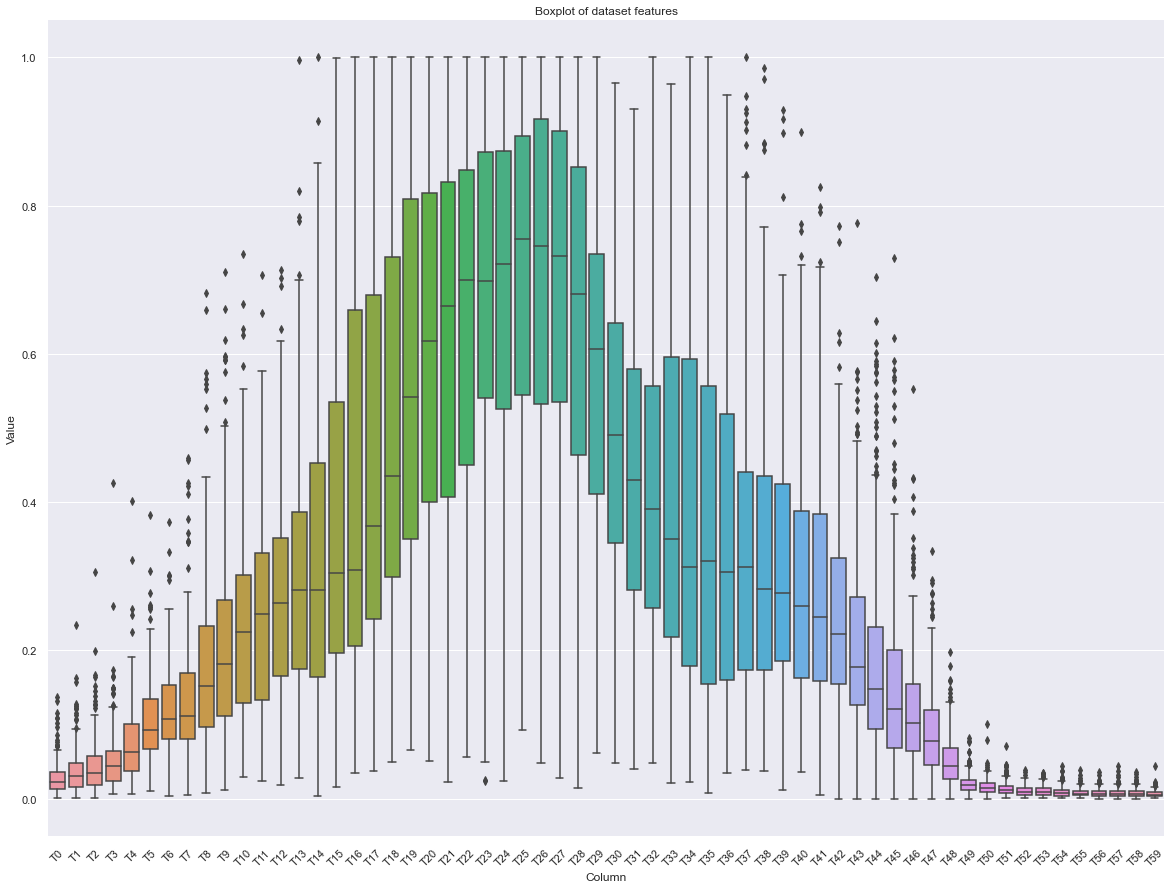

In [9]:
boxplot = sns.boxplot(data=features)
boxplot.set(title='Boxplot of dataset features',
            xlabel='Column',
            ylabel='Value')
sns.despine(offset=2)
plt.xticks(rotation=45)
plt.show()

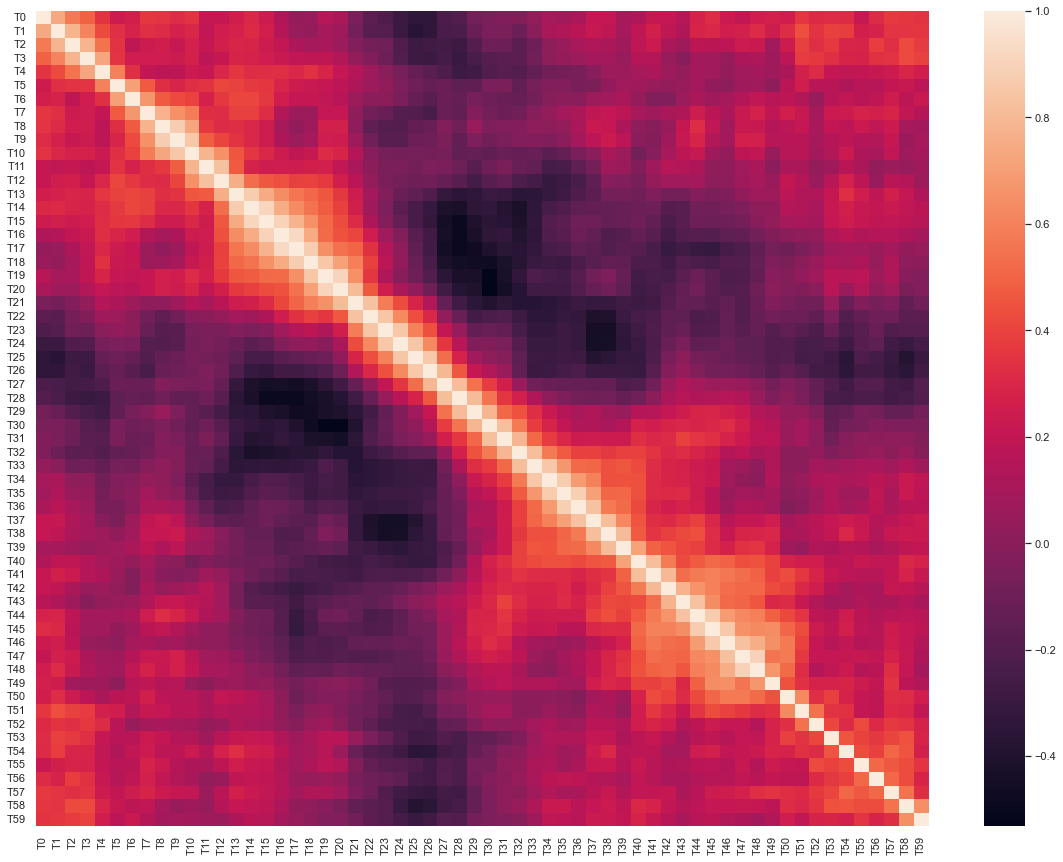

In [10]:
sns.heatmap(features.corr())
plt.show()

### Απάντηση στα ζητούμενα

1. Σύντομη Παρουσίαση Dataset και Περιγραφή Προβλήματος
     - Το γενικό πρόβλημα αποτελεί την κατηγοριοποίηση διαφόρων σημάτων με την βοήθεια ενός ταξινομητή. Ένα σύστημα SO.N.A.R. εκπέμπει σήματα, για τα οποία καλούμαστε να διακρίνουμε αν η επιφάνεια στην οποία ανακλώνται είναι μέταλλο ή πέτρα.

     - Το συγκεκριμένο dataset είναι ένα σύνολο μοτίβων από σήματα που λήφθηκαν από μεταλλικούς και πέτρινους κυλίνδρους. Κάθε γραμμή αποτελεί είτε έναν μεταλλικό είτε ένα πέτρινο κύλινδρο και οι μετρήσεις κατά μήκος της γραμμής είναι οι διάφορες ενέργειες των σημάτων σε διαφορετικές γωνίες και καταστάσεις του. Κάθε γραμμή περιέχει 60 μετρήσεις, καθώς και τον τύπο του κυλίνδρου στην 61η στήλη. Συνολικά υπάρχουν 208 τέτοιες γραμμές από τα διάφορα υλικά.  

2. Χρειάστηκε να κάνετε μετατροπές στα αρχεία plain text για την εισαγωγή του; αν ναι, ποιες είναι αυτές;
   - Δεν χρειάστηκε κάποια μετατροπή στα δεδομένα εκτός από το να διαβάζουμε το αρχείο σε μορφή csv (με την επιλογή να μην έχει το dataset κεφαλίδες).

3. Δώστε το πλήθος δειγμάτων και χαρακτηριστικών, και το είδος όλων των χαρακτηριστικών. Υπάρχουν μη διατεταγμένα χαρακτηριστικά και ποια είναι αυτά;
    - Συνολικά έχουμε 208 δείγματα. Από αυτά, τα 111 είναι μοτίβα τα οποία λαμβάνουμε από τους μεταλλικούς κυλίνδρους σε διαφορετικές γωνίες και καταστάσεις, ενώ τα 97 είναι μοτίβα τα οποία λαμβάνουμε από τις κυλινδρικές πέτρες κάτω από αντίστοιχες συνθήκες. Επίσης, για κάθε ένα από αυτά τα δείγματα, έχουμε 60 μετρήσεις, οι οποίες αναφέρονται σε ενέργεια, της οποίας η τιμή κυμαίνεται κάθε φορά από 0.0 έως 1.0 (στο dataset αυτές αναπαριστώνται ως float64), καθώς και ένα αναγνωριστικό που δείχνει την κλάση στην οποία ανήκει το δείγμα, με M για μέταλλο και R για πέτρα (στο dataset αυτό αναπαριστάται ως object). Αυτά τα "αναγνωριστικά" είναι και τα χαρακτηριστικά τα οποία είναι μη διατεταγμένα, εφόσον δεν είναι αριθμητικά, και έτσι δεν μπορούμε να τα διατάξουμε με κάποιο τρόπο.

4. Υπάρχουν επικεφαλίδες; Αρίθμηση γραμμών;
    - Το αρχείο αποτελείται μόνο από τα δεδομένα διαχωρισμένα με το σύμβολο `,` και δεν περιέχει ούτε κεφαλίδες ούτε αρίθμηση γραμμών. Κεφαλίδες προσθέσαμε εμείς ύστερα στο dataframe.

5. Ποιες είναι οι ετικέτες των κλάσεων και σε ποια κολόνα βρίσκονται;
    - Οι ετικέτες βρίσκονται στην στήλη 61 και έχουν τις τιμές `R` και `Μ` για πέτρα ή μέταλλο αντίστοιχα.

6. Υπάρχουν απουσιάζουσες τιμές; Πόσα είναι τα δείγματα με απουσιάζουσες τιμές και ποιο το ποσοστό τους επί του συνόλου;
    - Κάθε γραμμή έχει 60 μετρήσεις και ένα αναγνωριστικό που δείχνει την κλάση στην οποία ανήκει και έτσι δεν έχουμε απουσιάζουσες τιμές για κανένα από τα δείγματα (όπως φαίνεται και παραπάνω από τον κώδικα). Έτσι το ποσοστό των δειγμάτων με απουσιάζουσες τιμές είναι `0%`.

7. Ποιο είναι το πλήθος των κλάσεων και τα ποσοστά δειγμάτων τους επί του συνόλου; Αν θεωρήσουμε ότι ένα dataset είναι μη ισορροπημένο αν μια οποιαδήποτε κλάση είναι 1.5 φορά πιο συχνή από κάποια άλλη (60%-40% σε binary datasets) εκτιμήστε αν το dataset είναι ισορροπημένο ή όχι.
    - Το πλήθος των κλάσεων είναι 2, μεταλλικοί κύλινδροι και κυλινδρικές πέτρες. Τα ποσοστά δειγμάτων τους επί του συνόλου είναι αντίστοιχα #Μ = 111, και άρα `53.37%` και #R = 97 και άρα `46.63%`. Καμία κλάση δεν είναι 1.5 φορά πιο συχνή από κάποια άλλη, και συνεπώς το dataset είναι ισορροπημένο.

## Προετοιμασία

### Διαχείριση κατηγορικών δεδομένων

Καταρχάς, διαχωρίζουμε το σύνολο δεδομένων σε σύνολο εκπαίδευσης (train set) και σύνολο (test set) με 30% των δειγμάτων στο test set και στην συνέχεια θα κάνουμε διαχείριση κατηγορικών δεδομένων, όπως φαίνεται παρακάτω.

In [11]:
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.3)

In [12]:
train_labels

108    M
105    M
51     R
196    M
193    M
      ..
169    M
23     R
5      R
197    M
140    M
Name: Object, Length: 145, dtype: category
Categories (2, object): ['M', 'R']

In [13]:
le = LabelEncoder()
# we are fitting the Label Encoder with train_labels
# to avoid data leakage
le.fit(train_labels)
train_labels = pd.Series(le.transform(train_labels),
                         name='Object').astype('category')
test_labels = pd.Series(le.transform(test_labels),
                        name='Object').astype('category')

In [14]:
train_labels

0      0
1      0
2      1
3      0
4      0
      ..
140    0
141    1
142    1
143    0
144    0
Name: Object, Length: 145, dtype: category
Categories (2, int64): [0, 1]

Όπως φαίνεται και παραπάνω, το κατηγορικό (και μη διατεταγμένο) χαρακτηριστικό που διέκρινε τα δείγματα σε R και M, μέσω του label encoder τα αντιστοιχήσαμε σε 1 και 0 αντίστοιχα, για να είναι πιο εύκολη η επεξεργασία και η διαχείριση των δεδομένων μας και να είναι αποδοτικότερο το πρόγραμμά μας.

### Διαχείριση απουσιάζουσων τιμών

Τα δεδομένα δεν έχουν απουσιάζουσες τιμές και έτσι δεν χρειάζεται κάποια περαιτέρω προετοιμασία του dataset.

## Ταξινόμηση

Αρχικά θα δούμε πώς συμπεριφέρονται οι ταξινομητές χωρίς καμία βελτιστοποίηση (out-of-the-box) και με όλες τις παραμέτρους σε default τιμές.

In [15]:
out_of_the_box_scores = pd.DataFrame()


def add_scores(metric, classifier, score):
    global out_of_the_box_scores
    out_of_the_box_scores = out_of_the_box_scores.append(
        {
            'Metric': metric,
            'Classifier': classifier,
            'Score': score
        },
        ignore_index=True)

### Dummy classifier

In [16]:
dc = DummyClassifier()
dc.fit(train, train_labels)
preds = dc.predict(test)

score_acc = accuracy_score(test_labels, preds)
score_f1 = f1_score(test_labels, preds)

add_scores('Accuracy', 'Dummy', score_acc)
add_scores('F1', 'Dummy', score_f1)

### Gaussian Naive Bayes (GNB) classifier

In [17]:
gnb = GaussianNB()
gnb.fit(train, train_labels)
preds = gnb.predict(test)

score_acc = accuracy_score(test_labels, preds)
score_f1 = f1_score(test_labels, preds)

add_scores('Accuracy', 'Gaussian Naive Bayes', score_acc)
add_scores('F1', 'Gaussian Naive Bayes', score_f1)

### KNeirestNeighbors (kNN) classifier

In [18]:
knn = KNeighborsClassifier()
knn.fit(train, train_labels)
preds = knn.predict(test)

score_acc = accuracy_score(test_labels, preds)
score_f1 = f1_score(test_labels, preds)

add_scores('Accuracy', 'K-nearest neighbors', score_acc)
add_scores('F1', 'K-nearest neighbors', score_f1)

### Logistic Regression (LR) classifier

In [19]:
lr = LogisticRegression()
lr.fit(train, train_labels)
preds = lr.predict(test)

score_acc = accuracy_score(test_labels, preds)
score_f1 = f1_score(test_labels, preds)

add_scores('Accuracy', 'Logistic Regression', score_acc)
add_scores('F1', 'Logistic Regression', score_f1)

### Παρουσίαση επίδοσης out-of-the-box

In [20]:
out_of_the_box_scores.groupby('Classifier').apply(
    lambda a: a.drop('Classifier', axis=1)[:])

Metric     Score
Classifier                                
Dummy                0  Accuracy  0.555556
                     1        F1  0.000000
Gaussian Naive Bayes 2  Accuracy  0.730159
                     3        F1  0.746269
K-nearest neighbors  4  Accuracy  0.730159
                     5        F1  0.666667
Logistic Regression  6  Accuracy  0.809524
                     7        F1  0.785714

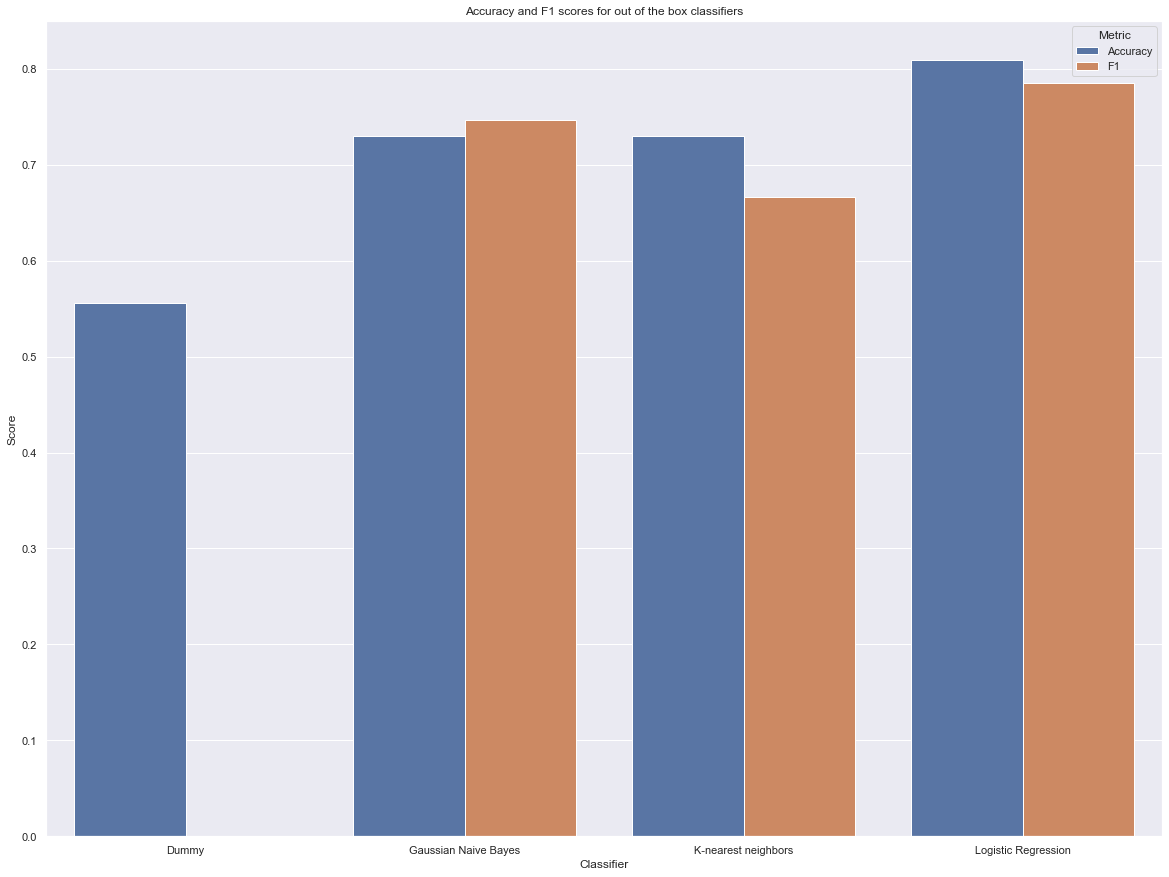

In [21]:
barplot = sns.barplot(data=out_of_the_box_scores,
                      y='Score',
                      x='Classifier',
                      hue='Metric')
barplot.set(title='Accuracy and F1 scores for out of the box classifiers')
plt.show()

Παραπάνω βλέπουμε την συμπεριφορά των ταξινομητών χωρίς καμία βελτιστοποίηση (out-of-the-box) και με όλες τις παραμέτρους σε default τιμές. Παρατηρούμε πως και για τις 2 μετρικές, οι επιδόσεις βελτιώνονται όσο περνάμε από τον Dummy στον Gaussian, και από τον Gaussian στον kNN, όπου και εμφανίζονται οι μεγαλύτερες επιδόσεις. Παρόλο που από τον kNN στον LR παρουσιάζεται μια πτώση και στις 2 μετρικές, η επίδοση του LR είναι καλύτερη στις 2 μετρικές και από τον Dummy αλλά και από τον Gaussian ταξινομητή. Αυτό σημαίνει πως χωρίς καμία βελτιστοποίηση κυρίως οι ταξινομητές kNN και LR εμφανίζουν την καλύτερη επίδοση στις υπό εξέταση μετρικές (με εμφανώς καλύτερη επίδοση στον kNN), ενώ ο Dummy παρουσιάζει την χαμηλότερη.

## Βελτιστοποίηση

### Ανάλυση Dataset

Με βάση το boxplot που φαίνεται παραπάνω παρατηρούμε πως θα βοηθούσε να κανονικοποιήσουμε τα δεδομένα μας. 

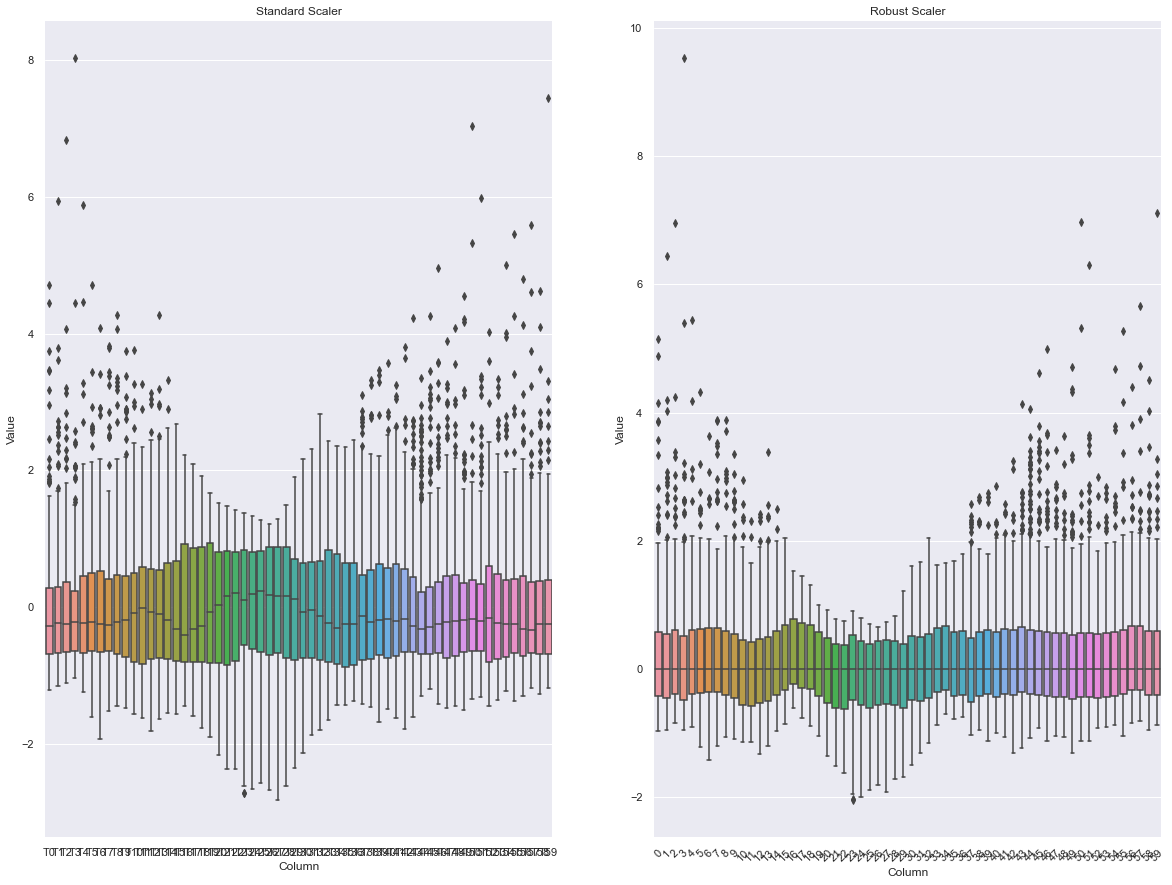

In [22]:
scaler = StandardScaler()
robust_scaler = RobustScaler()

scaler.fit_transform(features)
robust_scaler.fit_transform(features)

scaled_features = pd.DataFrame(scaler.fit_transform(features),
                               columns=features.columns)

fig, ax = plt.subplots(1, 2)

sns.boxplot(data=scaled_features, ax=ax[0]).set(title='Standard Scaler',
                                                xlabel='Column',
                                                ylabel='Value')
sns.despine(offset=2)
plt.xticks(rotation=45)
sns.boxplot(data=robust_scaler.fit_transform(features),
            ax=ax[1]).set(title='Robust Scaler',
                          xlabel='Column',
                          ylabel='Value')
sns.despine(offset=2)
plt.xticks(rotation=45)
plt.show()

Πράγματι, με την χρήση των Scaler φαίνεται ότι τα δεδομένα κανονικοποιήθηκαν, οπότε μπορούμε να χρησιμοποιήσουμε τον Standard Scaler στην προσπάθεια βελτίωσης των επιδόσεων των ταξινομητών.

### Βοηθητικές συναρτήσεις

In [37]:
preprocessing_scores = pd.DataFrame()


def train_best_model(cv_classifier, classifier, scoring_metric):
    global preprocessing_scores
    out_of_the_box_score = lambda m: out_of_the_box_scores.loc[
        (out_of_the_box_scores['Classifier'] == classifier) &
        (out_of_the_box_scores['Metric'] == m)]['Score'].values[0]
    pipe = cv_classifier.best_estimator_

    start_time = time.time()
    pipe.fit(train, train_labels)
    train_time = time.time() - start_time

    start_time = time.time()
    preds = pipe.predict(test)
    test_time = time.time() - start_time

    score_acc = accuracy_score(test_labels, preds)
    score_f1 = f1_score(test_labels, preds)

    preprocessing_scores = preprocessing_scores.append(
        {
            "Classifier": classifier,
            "Scoring_metric": scoring_metric,
            "Accuracy": score_acc,
            "ΔAccuracy": score_acc - out_of_the_box_score('Accuracy'),
            "F1": score_f1,
            "ΔF1": score_f1 - out_of_the_box_score('F1'),
            "Train_time": train_time,
            "Test_time": test_time,
            "Preds": preds
        },
        ignore_index=True)


def use_cv(operations, scoring_metric, param_grid, classifier):
    pipe = Pipeline(steps=operations, memory='tmp')
    cv_classifier = GridSearchCV(pipe,
                                 param_grid,
                                 cv=10,
                                 scoring=scoring_metric,
                                 n_jobs=-1)
    cv_classifier.fit(train, train_labels)

    print('''Statistics for {} on {} scoring metric:
          Best Score = {}
          Best Estimator = {}'''.format(classifier, scoring_metric,
                                        cv_classifier.best_score_,
                                        cv_classifier.best_estimator_))
    return cv_classifier

### Dummy classifier

Για την βελτιστοποίηση του Dummy Classifier χρησιμοποιήσαμε τον Standard Scaler, με τις υπερπαραμέτρους with_mean και with_std και το PCA, με την υπερπαράμετρο n_components να παίρνει τιμές από μια λίστα, όπως φαίνεται παρακάτω. Επίσης, στον ίδιο τον classifier βάλαμε να επιλέγει μεταξύ 4 στρατηγικών, και παραλείψαμε την στρατηγική constant, διότι δεν θέλουμε να προβλέπει μια συγκεκριμένη ετικέτα που θα δώσουμε εμείς. Δοκιμάσαμε τόσο την χρήση του Random Oversampler όσο και του Variance Threshold, αλλά κανένα από τα 2 δεν φάνηκε να βοηθάει στην βελτιστοποίηση των επιδόσεων.

In [38]:
operations = [('scaler', StandardScaler()), ('pca', PCA()),
              ('dummy', DummyClassifier())]

n_components = [i for i in range(10, 70, 10)]
dummy_strategy = ['stratified', 'most_frequent', 'prior', 'uniform']
with_mean = [True, False]
with_std = [True, False]

param_grid = dict(pca__n_components=n_components,
                  dummy__strategy=dummy_strategy,
                  scaler__with_mean=with_mean,
                  scaler__with_std=with_std)

#### Accuracy based scoring

In [39]:
dummy_acc_classifier = use_cv(operations, 'accuracy', param_grid, 'Dummy')

Statistics for Dummy on accuracy scoring metric:
          Best Score = 0.5861904761904764
          Best Estimator = Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler(with_mean=False)),
                ('pca', PCA(n_components=40)),
                ('dummy', DummyClassifier(strategy='uniform'))])


#### F1 based scoring

In [40]:
dummy_f1_classifier = use_cv(operations, 'f1', param_grid, 'Dummy')

Statistics for Dummy on f1 scoring metric:
          Best Score = 0.5495360195360195
          Best Estimator = Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler(with_mean=False, with_std=False)),
                ('pca', PCA(n_components=60)),
                ('dummy', DummyClassifier(strategy='stratified'))])


### Gaussian Naive Bayes (GNB) classifier

Για την βελτιστοποίηση του Gaussian Naive Bayes (GNB) classifier χρησιμοποιήσαμε τον Standard Scaler, με τις υπερπαραμέτρους with_mean και with_std και το PCA, με την υπερπαράμετρο n_components να παίρνει τιμές από μια λίστα, όπως φαίνεται παρακάτω. Επίσης, χρησιμοποιήσαμε στον ίδιο τον classifier την παράμετρο var_smoothing. Δοκιμάσαμε τόσο την χρήση του Random Oversampler όσο και του Variance Threshold, αλλά κανένα από τα 2 δεν φάνηκε να βοηθάει στην βελτιστοποίηση των επιδόσεων.

In [41]:
operations = [('scaler', StandardScaler()), ('pca', PCA()),
              ('gnb', GaussianNB())]

n_components = [i for i in range(10, 70, 10)]
var_smoothing = np.logspace(0, -9, 50)
with_mean = [True, False]
with_std = [True, False]

param_grid = dict(pca__n_components=n_components,
                  gnb__var_smoothing=var_smoothing,
                  scaler__with_mean=with_mean,
                  scaler__with_std=with_std)

#### Accuracy based scoring

In [42]:
gnb_acc_classifier = use_cv(operations, 'accuracy', param_grid,
                            'Gaussian Naive Bayes')

Statistics for Gaussian Naive Bayes on accuracy scoring metric:
          Best Score = 0.7742857142857142
          Best Estimator = Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('gnb', GaussianNB(var_smoothing=0.009540954763499934))])


#### F1 based scoring

In [43]:
gnb_f1_classifier = use_cv(operations, 'f1', param_grid, 'Gaussian Naive Bayes')

Statistics for Gaussian Naive Bayes on f1 scoring metric:
          Best Score = 0.7706418744654038
          Best Estimator = Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('gnb', GaussianNB(var_smoothing=0.009540954763499934))])


### KNeirestNeighbors (kNN) classifier

Για την βελτιστοποίηση του KNeirestNeighbors (kNN) classifier χρησιμοποιήσαμε τον Standard Scaler, με τις υπερπαραμέτρους with_mean και with_std και το PCA, με την υπερπαράμετρο n_components να παίρνει τιμές από μια λίστα, όπως φαίνεται παρακάτω. Επίσης, χρησιμοποιήσαμε στον ίδιο τον classifier την παράμετρο n_jobs ίση με -1, έτσι ώστε να χρησιμοποιηθούν όλοι οι processors στην αναζήτηση των γειτόνων. Επίσης, σαν υπερπαραμέτρους του classifier χρησιμοποίηθηκαν το n_neighbors, που είναι μια λίστα από την οποία επιλέγουμε τον "βέλτιστο" αριθμό από τους κοντινότερους γείτονες, το weights, που είναι η συνάρτηση βάρους που χρησιμοποιείται στην πρόβλεψη, καθώς και το metric, που είναι η μετρική της απόστασης. Δοκιμάσαμε τόσο την χρήση του Random Oversampler όσο και του Variance Threshold, αλλά κανένα από τα 2 δεν φάνηκε να βοηθάει στην βελτιστοποίηση των επιδόσεων.

In [44]:
operations = [('scaler', StandardScaler()), ('pca', PCA()),
              ('knn', KNeighborsClassifier(n_jobs=-1))]

n_components = [i for i in range(10, 70, 10)]
n_neighbors = list(range(1, 31, 2))
weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan", "minkowski"]
with_mean = [True, False]
with_std = [True, False]

param_grid = dict(pca__n_components=n_components,
                  knn__n_neighbors=n_neighbors,
                  knn__weights=weights,
                  knn__metric=metric,
                  scaler__with_mean=with_mean,
                  scaler__with_std=with_std)

#### Accuracy based scoring

In [45]:
knn_acc_classifier = use_cv(operations, 'accuracy', param_grid,
                            'K-nearest neighbors')

Statistics for K-nearest neighbors on accuracy scoring metric:
          Best Score = 0.909047619047619
          Best Estimator = Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=30)),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_jobs=-1,
                                      n_neighbors=1))])


#### F1 based scoring

In [46]:
knn_f1_classifier = use_cv(operations, 'f1', param_grid, 'K-nearest neighbors')

Statistics for K-nearest neighbors on f1 scoring metric:
          Best Score = 0.8983516483516484
          Best Estimator = Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=30)),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_jobs=-1,
                                      n_neighbors=1))])


### Logistic Regression (LR) classifier

Για την βελτιστοποίηση του Logistic Regression (LR) classifier χρησιμοποιήσαμε τον Standard Scaler, με τις υπερπαραμέτρους with_mean και with_std και το PCA, με την υπερπαράμετρο n_components να παίρνει τιμές από μια λίστα, όπως φαίνεται παρακάτω. Επίσης, χρησιμοποιήσαμε στον ίδιο τον classifier την παράμετρο n_jobs ίση με -1, έτσι ώστε να χρησιμοποιηθούν όλοι οι processors στην διαδικασία. Επίσης, σαν υπερπαραμέτρους του classifier χρησιμοποίηθηκαν ο solver saga, το penalty, το οποίο παίρνει μια από τις παρακάτω 3 τιμές, το fit_intercept, για το αν μια σταθερά πρέπει να προστεθεί στην συνάρτηση απόφασης, καθώς και το C, που παίρνει τιμές από μια λίστα, όπως φαίνεται παρακάτω. Δοκιμάσαμε τόσο την χρήση του Random Oversampler όσο και του Variance Threshold, αλλά κανένα από τα 2 δεν φάνηκε να βοηθάει στην βελτιστοποίηση των επιδόσεων.

In [47]:
operations = [('scaler', StandardScaler()), ('pca', PCA()),
              ('lr', LogisticRegression(n_jobs=-1, solver="saga"))]

n_components = [i for i in range(10, 70, 10)]
penalty = ["l1", "l2", "elasticnet"]
fit_intercept = [True, False]
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
with_mean = [True, False]
with_std = [True, False]

param_grid = dict(pca__n_components=n_components,
                  lr__penalty=penalty,
                  lr__fit_intercept=fit_intercept,
                  lr__C=C,
                  scaler__with_mean=with_mean,
                  scaler__with_std=with_std)

#### Accuracy based scoring

In [48]:
lr_acc_classifier = use_cv(operations, 'accuracy', param_grid,
                           'Logistic Regression')

Statistics for Logistic Regression on accuracy scoring metric:
          Best Score = 0.7676190476190475
          Best Estimator = Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler(with_std=False)),
                ('pca', PCA(n_components=10)),
                ('lr',
                 LogisticRegression(C=1, fit_intercept=False, n_jobs=-1,
                                    solver='saga'))])


#### F1 based scoring

In [49]:
lr_f1_classifier = use_cv(operations, 'f1', param_grid, 'Logistic Regression')

Statistics for Logistic Regression on f1 scoring metric:
          Best Score = 0.7666461479696773
          Best Estimator = Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler(with_std=False)),
                ('pca', PCA(n_components=10)),
                ('lr',
                 LogisticRegression(C=1, fit_intercept=False, n_jobs=-1,
                                    solver='saga'))])


## Εκπαίδευση και test βέλτιστων μοντέλων

In [ ]:
train_best_model(dummy_acc_classifier, 'Dummy', 'accuracy')

In [ ]:
train_best_model(dummy_f1_classifier, 'Dummy', 'f1')

In [ ]:
train_best_model(gnb_acc_classifier, 'Gaussian Naive Bayes', 'accuracy')

In [ ]:
train_best_model(gnb_f1_classifier, 'Gaussian Naive Bayes', 'f1')

In [ ]:
train_best_model(knn_acc_classifier, 'K-nearest neighbors', 'accuracy')

In [ ]:
train_best_model(knn_f1_classifier, 'K-nearest neighbors', 'f1')

In [ ]:
train_best_model(lr_acc_classifier, 'Logistic Regression', 'accuracy')

In [ ]:
train_best_model(lr_f1_classifier, 'Logistic Regression', 'f1')

## Αποτελέσματα και συμπεράσματα

In [58]:
preprocessing_scores[preprocessing_scores.columns.drop('Preds')].groupby(
    'Classifier').apply(lambda a: a.drop('Classifier', axis=1)[:])

Scoring_metric  Accuracy  ΔAccuracy        F1  \
Classifier                                                             
Dummy                0       accuracy  0.507937  -0.047619  0.415094   
                     1             f1  0.571429   0.015873  0.526316   
Gaussian Naive Bayes 2       accuracy  0.825397   0.095238  0.813559   
                     3             f1  0.825397   0.095238  0.813559   
K-nearest neighbors  4       accuracy  0.746032   0.015873  0.703704   
                     5             f1  0.746032   0.015873  0.703704   
Logistic Regression  6       accuracy  0.746032  -0.063492  0.724138   
                     7             f1  0.746032  -0.063492  0.724138   

                             ΔF1  Train_time  Test_time  
Classifier                                               
Dummy                0  0.415094    0.036904   0.001993  
                     1  0.526316    0.028453   0.002990  
Gaussian Naive Bayes 2  0.067291    0.012966   0.002992  
                     3  0.067291    0.013963   0.002993  
K-nearest neighbors  4  0.037037    0.014961   0.018948  
                     5  0.037037    0.014961   0.013962  
Logistic Regression  6 -0.061576    0.024933   0.001995  
                     7 -0.061576    0.019946   0.002994

In [59]:
to_plot_scores = preprocessing_scores[[
    'Classifier', 'Scoring_metric', 'Accuracy', 'F1'
]]

to_plot_differences = preprocessing_scores[[
    'Classifier', 'Scoring_metric', 'ΔAccuracy', 'ΔF1'
]]

In [60]:
migration = lambda x: {
    'Classifier':
        x,
    'Scoring_metric':
        'Out of the box',
    'Accuracy':
        out_of_the_box_scores.loc[
            (out_of_the_box_scores['Classifier'] == x) &
            (out_of_the_box_scores['Metric'] == 'Accuracy')]['Score'].values[0],
    'F1':
        out_of_the_box_scores.loc[
            (out_of_the_box_scores['Classifier'] == x) &
            (out_of_the_box_scores['Metric'] == 'F1')]['Score'].values[0],
}

old_scores = pd.DataFrame()
for clf in np.unique(out_of_the_box_scores['Classifier']):
    old_scores = old_scores.append(migration(clf), ignore_index=True)
to_plot_scores = old_scores.append(to_plot_scores, ignore_index=True)

[]

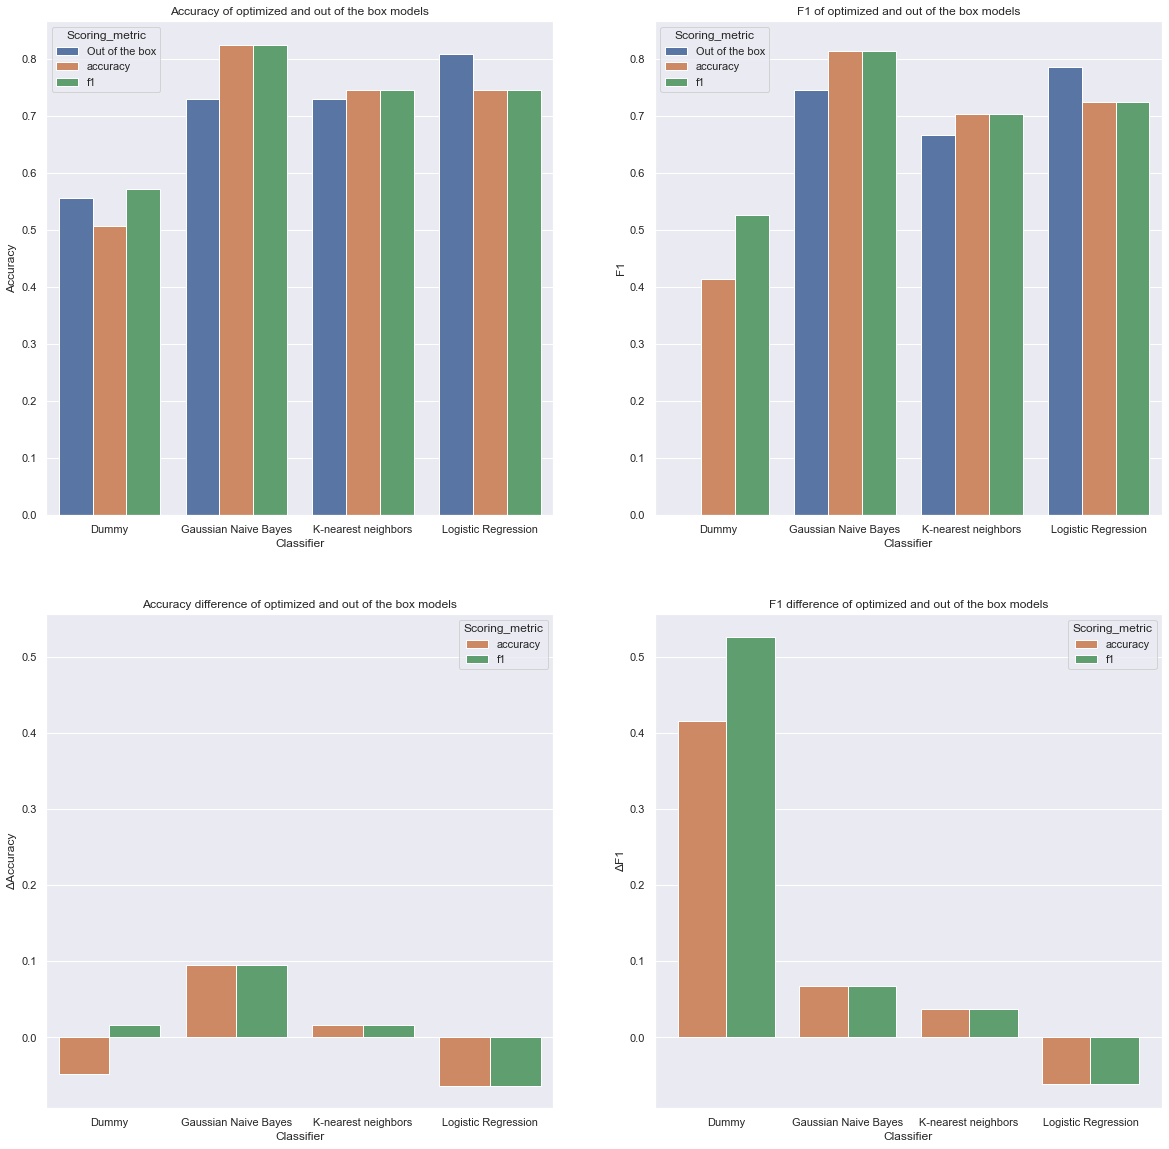

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axs[0][0].get_shared_y_axes().join(axs[0][0], axs[0][1])
axs[1][0].get_shared_y_axes().join(axs[1][0], axs[1][1])

sns.barplot(
    data=to_plot_scores,
    y='Accuracy',
    x='Classifier',
    hue="Scoring_metric",
    ax=axs[0][0]).set_title("Accuracy of optimized and out of the box models")

sns.barplot(data=to_plot_scores,
            y='F1',
            x='Classifier',
            hue="Scoring_metric",
            ax=axs[0][1]).set_title("F1 of optimized and out of the box models")

sns.barplot(data=to_plot_differences,
            y='ΔAccuracy',
            x='Classifier',
            hue="Scoring_metric",
            palette=["C1", "C2"],
            ax=axs[1][0]).set_title(
                "Accuracy difference of optimized and out of the box models")
sns.barplot(data=to_plot_differences,
            y='ΔF1',
            x='Classifier',
            hue="Scoring_metric",
            palette=["C1", "C2"],
            ax=axs[1][1]).set_title(
                "F1 difference of optimized and out of the box models")

plt.plot()

In [62]:
without_dummy = preprocessing_scores.loc[
    preprocessing_scores['Classifier'] != 'Dummy']
worst_model = without_dummy[without_dummy['Accuracy'] ==
                            without_dummy['Accuracy'].min()].iloc[0]
best_model = without_dummy[without_dummy['Accuracy'] ==
                           without_dummy['Accuracy'].max()].iloc[0]

print('''Worst model is {} with scoring metric {} and accuracy {:.3f}
Best model is {} with scoring metric {} and accuracy {:.3f}'''.format(
    worst_model['Classifier'], worst_model['Scoring_metric'],
    worst_model['Accuracy'], best_model['Classifier'],
    best_model['Scoring_metric'], best_model['Accuracy']))

Worst model is K-nearest neighbors with scoring metric accuracy and accuracy 0.746
Best model is Gaussian Naive Bayes with scoring metric accuracy and accuracy 0.825


In [63]:
worst_cf_matrix = confusion_matrix(worst_model['Preds'], test_labels)
best_cf_matrix = confusion_matrix(best_model['Preds'], test_labels)

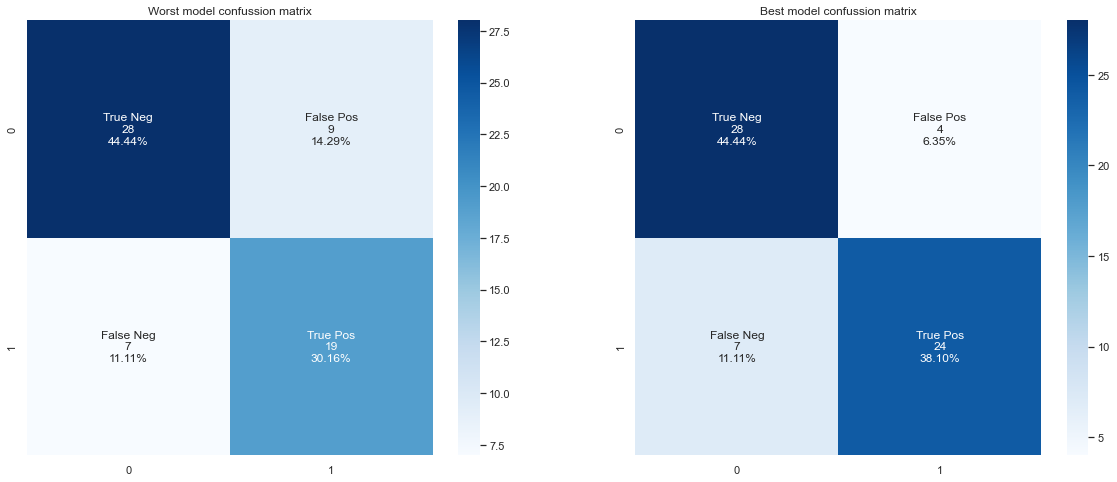

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in worst_cf_matrix.flatten()]
group_percentages = [
    '{0:.2%}'.format(value)
    for value in worst_cf_matrix.flatten() / np.sum(worst_cf_matrix)
]
labels = [
    f'{v1}\n{v2}\n{v3}'
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(worst_cf_matrix, annot=labels, fmt='', cmap='Blues',
            ax=axs[0]).set_title('Worst model confussion matrix')

group_counts = ['{0:0.0f}'.format(value) for value in best_cf_matrix.flatten()]
group_percentages = [
    '{0:.2%}'.format(value)
    for value in best_cf_matrix.flatten() / np.sum(best_cf_matrix)
]
labels = [
    f'{v1}\n{v2}\n{v3}'
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(best_cf_matrix, annot=labels, fmt='', cmap='Blues',
            ax=axs[1]).set_title('Best model confussion matrix')

plt.show()